<a href="https://colab.research.google.com/github/oilportrait/test_colab/blob/main/practiceProjectCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d mikoajfish99/carrots-vs-rockets-image-classification

 98% 88.0M/90.2M [00:05<00:00, 21.3MB/s]
100% 90.2M/90.2M [00:05<00:00, 16.0MB/s]


In [5]:
!mkdir sample

In [6]:
!unzip carrots-vs-rockets-image-classification.zip -d ./sample/

Archive:  carrots-vs-rockets-image-classification.zip
  inflating: ./sample/Images/Carrots/000333bbb9b7ae4c.jpg  
  inflating: ./sample/Images/Carrots/0022d08b808c7af6.jpg  
  inflating: ./sample/Images/Carrots/002469afe027814c.jpg  
  inflating: ./sample/Images/Carrots/004bdf076237f2fb.jpg  
  inflating: ./sample/Images/Carrots/00714e843dcac5e3.jpg  
  inflating: ./sample/Images/Carrots/007c1d785782989c.jpg  
  inflating: ./sample/Images/Carrots/00b69a01ddc58eaf.jpg  
  inflating: ./sample/Images/Carrots/00ce3578cf700c14.jpg  
  inflating: ./sample/Images/Carrots/0107069d8e6d0490.jpg  
  inflating: ./sample/Images/Carrots/0177c759a586204e.jpg  
  inflating: ./sample/Images/Carrots/01b32dadf81ac313.jpg  
  inflating: ./sample/Images/Carrots/02195c0230ff7cb8.jpg  
  inflating: ./sample/Images/Carrots/028711cdda533c78.jpg  
  inflating: ./sample/Images/Carrots/02924ae5412e1165.jpg  
  inflating: ./sample/Images/Carrots/02fdcb9074408b91.jpg  
  inflating: ./sample/Images/Carrots/030c8ab76

In [33]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
import os
import shutil
import numpy as np
import cv2

데이터를 분리하기 위해서 데이터가 들어있는 경로를 저장합니다.

In [34]:
dataPath = './sample/Images'
carrotsPath = os.path.join(dataPath, 'Carrots')
rocketsPath = os.path.join(dataPath, 'Rockets')

이미지 데이터를 불러옵니다.

In [35]:
#저장할 리스트들을 가져옵니다.
images = []
labels = []

In [36]:
# 당근 이미지들을 불러옵니다.
for filename in os.listdir(carrotsPath):
      img = cv2.imread(os.path.join(carrotsPath, filename))# 각 사진들의 경로를 저장합니다.
      img = cv2.resize(img, (150, 150))  # 모든 이미지의 사이즈를 통일시킵니다
      images.append(img) #작업이 완료된 이미지들을 기존에 지정한 리스트에 저장합니다.
      labels.append(0) # 레이블을 지정합니다.

In [37]:
# 로켓 이미지들도 동일한 과정을 거쳐서  불러옵니다.
for filename in os.listdir(rocketsPath):
      img = cv2.imread(os.path.join(rocketsPath, filename))
      img = cv2.resize(img, (150, 150))
      images.append(img)
      labels.append(1)

연산이 무겁지 않게 하기 위해서 numpy array로 변경합니다.

In [38]:
images = np.array(images) #이 데이터의 형태는 150x150x3(RGB) 입니다.
labels = np.array(labels)

train data를 80% validation data를 20% test data를 10%로 나눕니다.

In [46]:
xTrain, xTemp, yTrain, yTemp = train_test_split(images, labels, test_size=0.3, random_state=42)
xVal, xTest, yVal, yTest, = train_test_split(xTemp, yTemp, test_size=0.33, random_state=42)

CNN은 Augmentation을 반영하지 못하므로 임의로 변형시켜서 데이터 셋에 추가합니다.

In [54]:
train_datagen = ImageDataGenerator(
    rescale=1./255, # train data의 Normalization을 수행합니다.
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
)

# validation과  test는 실제 상황을 반영해야하므로 Augmentation을 적용해서는 안됩니다.
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow(xTrain, yTrain, batch_size=32)
val_generator = val_datagen.flow(xVal, yVal, batch_size=32)

CNN모델의 구조를 결정합니다.

In [48]:
# 굳이 커널의 개수를 2의 제곱꼴로 설정하는것은 컴퓨터의 메모리 할당방식과 일치시키 위해서입니다.

model = models.Sequential([
    layers.Conv2D(64, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(256, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(512, activation='relu'), # FC layer 구현
    layers.Dense(1, activation='sigmoid')
])

모델의 최적화 기법을 지정합니다.

In [49]:
model.compile(loss='binary_crossentropy', # loss function을 정의합니다.
              optimizer=optimizers.Adam(), # loss fuction의 최소값을 구하는 방법을 설정합니다
              metrics=['accuracy']) # 잘 수행되는지 모니터링합니다.

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True) # early stopping을 설정합니다.

모델 학습을 시작합니다.

In [50]:
history = model.fit(
    train_generator,
    steps_per_epoch=len(xTrain) // 32,
    #steps_per_epoch는 에포크당 배치를 거쳐가는 횟수를 의미합니다.
    #그러므로 이미지 샘플이 모든 훈련과정에서 한번씩 사용되기 위해서 배치 크기로 나눕니다.
    epochs=30,
    validation_data=val_generator,
    validation_steps=len(xVal) // 32,
    callbacks=[early_stop]
)

Epoch 1/30
6/6 [==============================] - 3s 219ms/step - loss: 2.2976 - accuracy: 0.5055 - val_loss: 0.8160 - val_accuracy: 0.5312
Epoch 2/30
6/6 [==============================] - 1s 207ms/step - loss: 0.6972 - accuracy: 0.6146 - val_loss: 0.6227 - val_accuracy: 0.5625
Epoch 3/30
6/6 [==============================] - 1s 199ms/step - loss: 0.5312 - accuracy: 0.7604 - val_loss: 0.4358 - val_accuracy: 0.9062
Epoch 4/30
6/6 [==============================] - 1s 193ms/step - loss: 0.3974 - accuracy: 0.8297 - val_loss: 0.4279 - val_accuracy: 0.8438
Epoch 5/30
6/6 [==============================] - 1s 155ms/step - loss: 0.3178 - accuracy: 0.8736 - val_loss: 0.4652 - val_accuracy: 0.7812
Epoch 6/30
6/6 [==============================] - 1s 198ms/step - loss: 0.3570 - accuracy: 0.8229 - val_loss: 0.2669 - val_accuracy: 0.8750
Epoch 7/30
6/6 [==============================] - 1s 168ms/step - loss: 0.3706 - accuracy: 0.8646 - val_loss: 0.4397 - val_accuracy: 0.8125
Epoch 8/30
6/6 [====

모델을 테스트에 적용시켜서 평가해봅시다.

In [53]:
testImages = xTest / 255.0 # Test Image에 대한 normalization을 수행합니다.

test_loss, test_accuracy = model.evaluate(testImages, yTest, verbose=2) # 정확도를 계산합니다.
print(f"\nTest accuracy: {test_accuracy*100:.2f}%")

1/1 - 0s - loss: 0.3078 - accuracy: 0.9355 - 42ms/epoch - 42ms/step

Test accuracy: 93.55%


추가로  ROC 커브도 그려보았습니다.

1/1 [==============================] - 0s 82ms/step


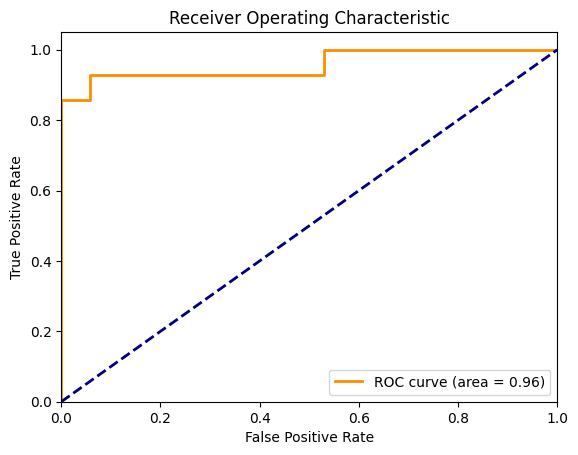

In [52]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt

y_pred_prob = model.predict(testImages)
y_pred = np.round(y_pred_prob).astype(int)

fpr, tpr, thresholds = roc_curve(yTest, y_pred_prob)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()